In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge,Lasso,ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV,learning_curve


In [77]:
X_train = pd.read_csv('csv/X_train.csv')
X_test = pd.read_csv('csv/X_test.csv')
y_train = pd.read_csv('csv/y_train.csv')
y_test = pd.read_csv('csv/y_test.csv') 

# Algorithme de régression linéaire Ridge

### Recherche du meilleur alpha

In [78]:

# modelRid = make_pipeline( PolynomialFeatures(degree=2,interaction_only=False),GridSearchCV(Ridge(),param_grid={'alpha': [0,0.01,0.05,0.1,1,10,100,300,400,500,1000,10000]},
#                                  scoring='r2',
#                                  refit=True))

# for exp in range(2):
#     affinage = modelRid.fit(X_train,y_train)[1].best_params_["alpha"]
#     liste_param = [param for param in np.arange(affinage - (affinage/10**(exp+1)),affinage + (affinage/10**(exp+1)), 10**(-exp))]
#     modelRid = make_pipeline( PolynomialFeatures(degree=2,interaction_only=False),GridSearchCV(Ridge(),param_grid={'alpha': liste_param},
#                                  scoring='r2',
#                                  refit=True))

# best_alpha = modelRid.fit(X_train,y_train)[1].best_params_["alpha"]
# best_alpha


In [79]:
best_alpha=1109.90999999998

# Utilisation du model Ridge

In [80]:
modelRid = make_pipeline( PolynomialFeatures(degree=2),Ridge(alpha=best_alpha))

## Courbe d'apprentissage

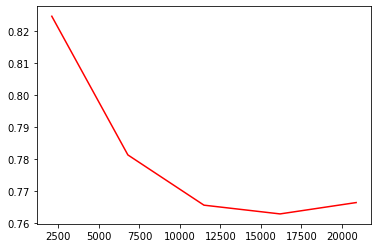

In [81]:
X = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(modelRid,X,y, cv=30,return_times=True)

plt.plot(train_sizes,np.mean(train_scores,axis=1),'r')

plt.show()


## Prédiction

In [82]:
modelRid.fit(X_train,y_train)
modelRid.score(X_train,y_train)

0.7649663651319676

In [83]:
modelRid.score(X_test,y_test)

0.7542500665302119

In [84]:
y_prediction = modelRid.predict(X_test)
df_prediction = pd.DataFrame(y_prediction,columns=["prediction"])

In [85]:
df_prediction["resultat"] = y_test['price']

In [86]:
df_prediction["diff"]= ((df_prediction["resultat"] - df_prediction["prediction"])**2)**(1/2)

In [87]:
df_prediction.describe()

,prediction,resultat,diff
count,4.320000e+03,4.320000e+03,4.320000e+03
mean,5.391602e+05,5.416757e+05,1.276558e+05
std,3.201532e+05,3.639041e+05,1.274517e+05
min,4.229769e+04,8.400000e+04,4.682307e+01
25%,3.590117e+05,3.250000e+05,5.028022e+04
50%,4.462792e+05,4.550000e+05,9.872483e+04
75%,6.093981e+05,6.513250e+05,1.600454e+05
max,6.439199e+06,7.700000e+06,1.292294e+06


In [88]:
df_prediction

,prediction,resultat,diff
0,3.661166e+05,338900.0,27216.609265
1,4.427872e+05,543000.0,100212.815028
2,4.309966e+05,565000.0,134003.396672
3,1.108958e+06,880000.0,228957.840257
4,6.127544e+05,562000.0,50754.414131
...,...,...,...
4315,4.830632e+05,677900.0,194836.775003
4316,3.483526e+05,192950.0,155402.569822
4317,3.928248e+05,330000.0,62824.808194
4318,3.687762e+05,379900.0,11123.847625


In [89]:
# modelLasso = make_pipeline( PolynomialFeatures(2),GridSearchCV(Lasso(),param_grid={'alpha': [0.0001,0.001,0.01,0.05,0.1,0.5,1],"tol":[0.0001,0.001,0.01,0.05,0.1,0.5,1]},
#                                                                 cv=2,refit=True))
# modelLasso.fit(X_train,y_train)

In [90]:
# modelLasso.score(X_test,y_test)

In [91]:
# prediction = modelLasso.predict(X_test)
# prediction

In [92]:
# modelEN = make_pipeline( PolynomialFeatures(2),GridSearchCV(ElasticNet(),param_grid={'alpha': [0.0001,0.001,0.01,0.05,0.1,0.5,1],"tol":[0.0001,0.001,0.01,0.05,0.1,0.5,1]},
#                                                                 cv=2,refit=True))
# modelEN.fit(X_train,y_train)
# print("")

In [93]:
# modelEN.score(X_test,y_test)

In [94]:
# prediction = modelEN.predict(X_test)
# prediction

# LinearRegression

In [95]:
modelLR = make_pipeline( PolynomialFeatures(1),LinearRegression())
modelLR.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('linearregression', LinearRegression())])

In [96]:
modelLR.score(X_test,y_test)

0.7138978646400764

In [97]:
y_lr_prediction = modelLR.predict(X_test)
y_lr_prediction

array([[331986.85766602],
       [422482.85766602],
       [427602.85766602],
       ...,
       [399954.85766602],
       [384722.85766602],
       [367154.85766602]])

# Methode naif

In [98]:
modelDummy = DummyRegressor()
modelDummy.fit(X_train,y_train)
modelDummy.score(X_test,y_test)

-2.5762973467680084e-05

In [99]:
prediction = modelDummy.predict(X_test)
prediction

array([539828.85766381, 539828.85766381, 539828.85766381, ...,
       539828.85766381, 539828.85766381, 539828.85766381])